# Data Pre-Processing

In [37]:
import pandas as pd
import numpy as np
import data_handler as dh
from ucimlrepo import fetch_ucirepo
from matplotlib import pyplot as plt

In [19]:
bank_marketing = fetch_ucirepo(id=222)
X_bank_marketing = bank_marketing.data.features
y_bank_marketing = bank_marketing.data.targets

wine_quality = fetch_ucirepo(id=186)
X_wine_quality = wine_quality.data.features
y_wine_quality = wine_quality.data.targets

We pre-process the bank marketing data like last week.

In [20]:
X_bank_marketing = X_bank_marketing.drop(['month', 'day_of_week'],
                                         axis=1)  # drop features without values for prediction

X_bank_marketing = X_bank_marketing.fillna(0)

X_bank_marketing = pd.get_dummies(X_bank_marketing).astype(np.float64)

X_bank_marketing = (X_bank_marketing - X_bank_marketing.min()) / (X_bank_marketing.max() - X_bank_marketing.min())

y_bank_marketing.loc[:, 'y'] = y_bank_marketing['y'].map({'no': 0, 'yes': 1}).astype(
    np.float64)  # convert targets to numeric values

In [21]:
X_wine_quality = (X_wine_quality - X_wine_quality.min()) / (X_wine_quality.max() - X_wine_quality.min())

In [22]:
X_bank_train, X_bank_test, y_bank_train, y_bank_test = dh.split_data(X_bank_marketing, y_bank_marketing, 0.8)
X_wine_train, X_wine_test, y_wine_train, y_wine_test = dh.split_data(X_bank_marketing, y_bank_marketing, 0.8)

# Regularization

We are going to implement Ridge Regression according to IBM (https://www.ibm.com/topics/ridge-regression), since there does not seem to be an algorithm provided.
We use MSE as loss function.
$$
Loss = \frac{1}{n} \sum_{i=1}^n (Y_i - \hat{Y}_i)^2 + \lambda \sum_{j=1}^P \beta_j^2
$$

We already know the gradient of MSE from week 3, we just have to add the gradient of the L2 term ($2 \lambda \beta$).

$$
\Delta_{\beta} Loss = -\frac{2}{n} X ^ T (y - X \beta) + 2 \lambda \beta
$$


In [34]:
class RidgeRegression:
    def __init__(self):
        self.B = None
        self.L2 = None

    def fit(self, X_train, y_train, X_test, y_test, initial_learning_rate, regularization_constant, i_max,
            batch_size=50):
        """
        Fits the model to the given Data.
        :param X_train: 
        :param y_train: 
        :param X_test:
        :param y_test:
        :param initial_learning_rate: 
        :param regularization_constant: 
        :param batch_size: 
        :param i_max: Maximum number of iterations.
        :return: 
        """
        # TODO: we have no convergence criterion
        n = X_train.shape[0]
        d = X_train.shape[1]

        # Bold Driver parameters
        bold_driver_reward = 1.1
        bold_driver_penalty = 0.5

        self.B = np.zeros(d)
        self.L2 = 0

        def mini_GDB(f, f_grad):
            prev_loss = float('inf')
            learning_rate = initial_learning_rate
            train_rmse_history = []
            test_rmse_history = []

            for epoch in range(1, i_max + 1):
                indices = np.random.permutation(n)
                X_shuffled = X_train[indices]
                y_shuffled = y_train[indices]

                for i in range(0, n, batch_size):
                    X_batch = X_shuffled[i:i + batch_size]
                    y_batch = y_shuffled[i:i + batch_size]

                    current_loss = f(X_batch, y_batch)
                    grad = f_grad(X_batch, y_batch)

                    # We use bold driver for adjusting the learning rate
                    if current_loss < prev_loss:
                        learning_rate *= bold_driver_reward

                    else:
                        learning_rate *= bold_driver_penalty

                    # print(f'Learning rate: {learning_rate}, type: {type(learning_rate)}')
                    # print(f'Grad: {grad}, tpye: {type(grad)}')
                    # print(f'Weights: {self.B}, type: {self.B}')

                    self.B -= learning_rate * grad
                    self.L2 -= learning_rate * np.mean(grad)

                    prev_loss = current_loss

                train_rmse = self._rmse(X_train, y_train)
                test_rmse = self._rmse(X_test, y_test)

                train_rmse_history.append(train_rmse)
                test_rmse_history.append(test_rmse)

            return train_rmse_history, test_rmse_history

        def mse(X_batch, y_batch):
            predictions = X_batch @ self.B
            return np.mean((y_batch - predictions) ** 2) + regularization_constant * np.sum(self.B ** 2)

        def mse_grad(X_batch, y_batch):
            predictions = X_batch @ self.B
            return ((-2 / len(y_batch)) * (X_batch.T @ (y_batch - predictions)) + (
                    2 * regularization_constant * self.B)).astype(np.float64)

        return mini_GDB(mse, mse_grad)

    def _rmse(self, X, y):
        predictions = X @ self.B
        return np.sqrt(np.mean((y - predictions) ** 2))

    def predict(self, X):
        """
        Predicts the target values for the given Data.
        :param X: Input features.
        :return: Predicted target values.
        """
        if self.B is None:
            raise ValueError('Please call fit() before predicting.')

        return X @ self.B


In [35]:
model = RidgeRegression()

train_rmse_history, test_rsme_history = model.fit(X_wine_train, y_wine_train, X_wine_test, y_wine_test,
                                                  initial_learning_rate=0.1, regularization_constant=0.1, i_max=200)

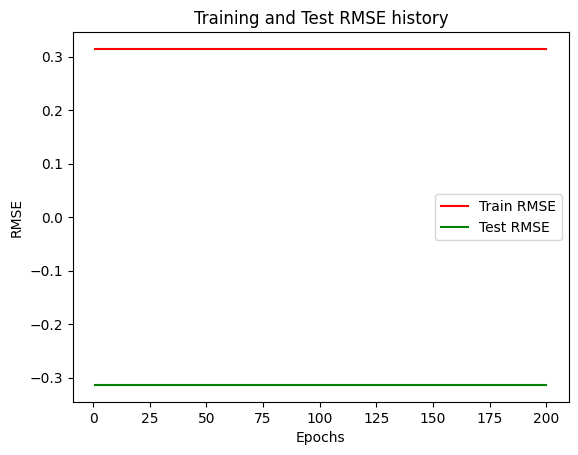

In [40]:
plt.plot(range(1, len(train_rmse_history) + 1), train_rmse_history, label='Train RMSE', color='red')
plt.plot(range(1, len(test_rsme_history) + 1), -np.array(test_rsme_history), label='Test RMSE', color='green')

plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.title('Training and (negative) Test RMSE history')
plt.legend()

plt.show()
plt.close()